In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd # For csv
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle
import json

## Protein Disorder Prediction

### Data set-up

Import drive, so that preprocessed data can be used in Notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [3]:
def read_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_data.json', 'r') as infile:
    return json.load(infile)

def read_cleaned_pandas_data():
  return pd.read_json('/content/drive/My Drive/Colab Notebooks/diss_files/idr_pandas_table.json')

protein_sequences_n_ids = read_sequences()
fully_clean_pandas_data = read_cleaned_pandas_data()

Amino Acids Channeled Image

In [4]:
def make_empty_image(seq):
  img = {
    'A' : np.zeros(len(seq)),
    'C' : np.zeros(len(seq)),
    'D' : np.zeros(len(seq)),
    'E' : np.zeros(len(seq)),
    'F' : np.zeros(len(seq)),
    'G' : np.zeros(len(seq)),
    'H' : np.zeros(len(seq)),
    'I' : np.zeros(len(seq)),
    'K' : np.zeros(len(seq)),
    'L' : np.zeros(len(seq)),
    'M' : np.zeros(len(seq)),
    'N' : np.zeros(len(seq)),
    'P' : np.zeros(len(seq)),
    'Q' : np.zeros(len(seq)),
    'R' : np.zeros(len(seq)),
    'S' : np.zeros(len(seq)),
    'T' : np.zeros(len(seq)),
    'V' : np.zeros(len(seq)),
    'W' : np.zeros(len(seq)),
    'Y' : np.zeros(len(seq))
  }
  return img

def make_image(seq):
  # Makes 20 empty channels
  channeled_img = make_empty_image(seq)
  # Loop over each amino acid in the sequence - 
  # for its position add a 1 to the letter identifier channel
  for i, char in enumerate(seq):
    # Updates array due to arrays being like pointers
    channeled_img.get(char)[i] = 1

  return channeled_img

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [5]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, amino_map, protein_sequences, transform=None):
        self.disorder_prot = pandas_table
        self.sequence_map = make_image
        self.sequences = protein_sequences
        self.tranform = transform

    def __len__(self):
        return len(self.disorder_prot)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.disorder_prot['acc'].loc[idx]
        idrs = self.disorder_prot['disordered_regions'].loc[idx]
        
        # Get sequence
        protein_sequence = self.sequences.get(acc)
        # Vectorise amino acids
        protein_sequence_image = self.sequence_map(protein_sequence)
        # Converts channel dictionary to 2D array
        protein_sequence_image = np.array(list(protein_sequence_image.values()))
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'image': protein_sequence_image, 'label': disorder_label}
        return get_dict

Separate train/validation/test datasets. Currently using a 60/20/20 in place split from generated pandas data.

In [8]:
randomly_sampled_pandas_data = fully_clean_pandas_data.sample(frac = 1, random_state=117).reset_index()

train_len = round(len(randomly_sampled_pandas_data) * (60/100))
train_pandas_data = randomly_sampled_pandas_data[0:train_len]
train_dataset = DisProtDataset(train_pandas_data, make_image, protein_sequences_n_ids)

valid_len = round((len(randomly_sampled_pandas_data) * (20/100)))
valid_pandas_data = randomly_sampled_pandas_data[train_len:(train_len+valid_len)]
# Reset index helps clean up index column after slicing.
valid_pandas_data = valid_pandas_data.reset_index(drop=True)
validation_dataset = DisProtDataset(valid_pandas_data, make_image, protein_sequences_n_ids)

test_len = len(randomly_sampled_pandas_data) - (train_len + valid_len)
test_pandas_data = randomly_sampled_pandas_data[(train_len+valid_len):]
test_pandas_data = test_pandas_data.reset_index(drop=True)
test_dataset = DisProtDataset(test_pandas_data, make_image, protein_sequences_n_ids)

train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

### Loading PyTorch NN models.

In [9]:
class FCN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(20, 10, 21, padding=10)
        self.conv2 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv3 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv4 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv5 = nn.Conv1d(10, 1, 21, padding=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        # Removal of final activation function due to Logits Loss
        #x = torch.sigmoid(self.conv5(x))
        return x

In [10]:
# Reads trained model from storage
def read_model():
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/cnn_net.pth'

  loaded_model = FCN_Net()
  loaded_model.load_state_dict(torch.load(PATH))
  return loaded_model

loaded_model = read_model()
loaded_model

FCN_Net(
  (conv1): Conv1d(20, 10, kernel_size=(21,), stride=(1,), padding=(10,))
  (conv2): Conv1d(10, 10, kernel_size=(21,), stride=(1,), padding=(10,))
  (conv3): Conv1d(10, 10, kernel_size=(21,), stride=(1,), padding=(10,))
  (conv4): Conv1d(10, 10, kernel_size=(21,), stride=(1,), padding=(10,))
  (conv5): Conv1d(10, 1, kernel_size=(21,), stride=(1,), padding=(10,))
)

### Matthews correlation coefficient

MCC = $\frac{(TP * TN) - (FP * FN)}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$

Where the variables are:
- TP - when a disordered protein is classified as disordered. A 1 is said to be a 1.
- FP - when an ordered protein is classified as disordered.   A 0 is said to be a 1.
- TN - when an ordered protein is classified as ordered.      A 0 is said to be a 0.
- FN - when an disordered protein is classified as ordered.   A 1 is said to be a 0.

In [11]:
# Turns the prediction to a list of ordered/disordered (0/1) predictions
def pred_round(predicted_label):
  predicted_label[predicted_label>=0.5] = 1
  predicted_label[predicted_label<0.5] = 0
  return predicted_label

def class_correctness(predicted_label, true_label):
  # Calculating TN value
  # Sum as True values take on the value of 1
  TN = (true_label[predicted_label == 0] == 0).sum()
  # Calculating FN
  FN = (true_label[predicted_label == 0] == 1).sum()
  # Calculating TP
  TP = (true_label[predicted_label == 1] == 1).sum()
  FP = (true_label[predicted_label == 1] == 0).sum()
  #print("TP: ",TP,"\nFP: ",FP,"\nTN: ",TN,"\nFN: ",FN)
  return {'TN':TN, 'FN':FN, 'TP':TP, 'FP':FP}

def calc_MCC(TP, TN, FP, FN):
  num = (TP * TN) - (FP * FN)
  den = torch.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
  if den == 0:
    return 0
  MCC = num / den
  #print("MCC: ", MCC)
  return MCC

Pre-made confusion matrix

In [12]:
#https://onestopdataanalysis.com/confusion-matrix-python/

import seaborn
import matplotlib.pyplot as plt
 
 
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    #https://stackoverflow.com/questions/60240694/suppress-scientific-notation-in-sklearn-metrics-plot-confusion-matrix
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='g')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    plt.show()
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    #plt.close()


Testing with one sequence

In [13]:
testIter = iter(test_loader)
test_seq = next(testIter)
input_seq = test_seq.get('image')
input_seq = input_seq.type(torch.FloatTensor)
true_label = test_seq.get('label')
true_label = true_label.type(torch.FloatTensor)

with torch.no_grad():
  predicted_label = loaded_model(input_seq)

predicted_label = torch.sigmoid(predicted_label)
predicted_label = torch.squeeze(predicted_label)
true_label = torch.squeeze(true_label)

pred_lab = pred_round(predicted_label)
dic = class_correctness(pred_lab, true_label)

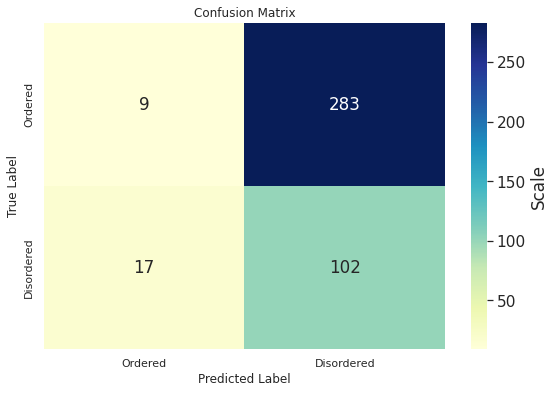

In [14]:
# define data
data = [[dic.get('TN'), dic.get('FP')],
        [dic.get('FN'), dic.get('TP')]]
 
# define labels
labels = ["Ordered", "Disordered"]
 
# create confusion matrix
plot_confusion_matrix(data, labels, "confusion_matrix.png")

Dataset MCC

In [20]:
def calculate_dataset_mcc(name, dataset):
  TP = TN = FP = FN = 0

  mcc_sum = 0

  for seq in dataset:
    input_seq = seq.get('image')
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      predicted_label = loaded_model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    correct_dict = class_correctness(pred_lab, true_label)
    TP += (correct_dict.get('TP'))
    TN += (correct_dict.get('TN'))
    FP += (correct_dict.get('FP'))
    FN += (correct_dict.get('FN'))

    mcc_sum += calc_MCC(correct_dict.get('TP'), correct_dict.get('TN'), correct_dict.get('FP'), correct_dict.get('FN'))


  # Using all labels vs using average sequence mcc score over dataset
  mcc_raw = calc_MCC(torch.Tensor([TP]), torch.Tensor([TN]), torch.Tensor([FP]), torch.Tensor([FN]))
  print(name+" MCC score: ", mcc_raw)

  print("MCC average: ", mcc_sum / len(dataset))

  data = [[TN, FP],
        [FN, TP]]
  labels = ["Ordered", "Disordered"]
  plot_confusion_matrix(data, labels, "confusion_matrix.png")

Test MCC score:  tensor([0.2504])
MCC average:  tensor(0.2005)


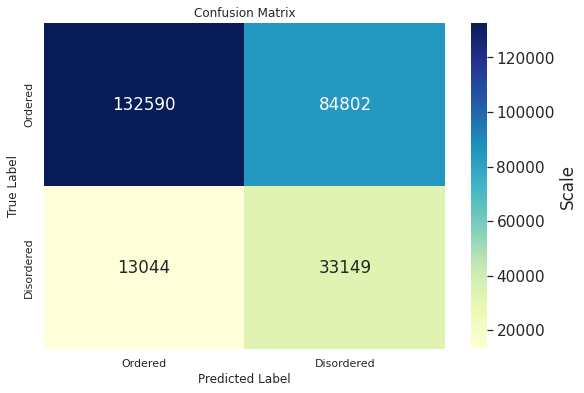

In [21]:
calculate_dataset_mcc("Test", test_loader)

Other standard evaluation metrics

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234


Accuracy = $\frac{Number of Correct predictions}{Total number of predictions made}$ = $\frac{TP+TN}{TP+TN+FP+FN}$

Precision = $\frac{TP}{TP+FP}$

Recall = $\frac{TP}{TP+FN}$

Recall = $\frac{2 * precision * recall}{precision+recall}$

In [22]:
def calculate_dataset_metrics(name, dataset):
  TP = TN = FP = FN = 0

  for seq in dataset:
    input_seq = seq.get('image')
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      predicted_label = loaded_model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    correct_dict = class_correctness(pred_lab, true_label)
    TP += (correct_dict.get('TP'))
    TN += (correct_dict.get('TN'))
    FP += (correct_dict.get('FP'))
    FN += (correct_dict.get('FN'))

  data = [[TN, FP],
        [FN, TP]]
  labels = ["Ordered", "Disordered"]
  plot_confusion_matrix(data, labels, "confusion_matrix.png")


  accuracy = (TP+TN) / (TP+TN+FP+FN)
  precision = TP / (TP+FP)
  recall = TP / (TP+FN)
  f1score = (2*precision*recall) / (precision + recall)


  print("Accuracy:\t ", accuracy)
  print("Precision:\t ", precision)
  print("Recall:\t\t ", recall)
  print("F1 score:\t ", f1score)
  


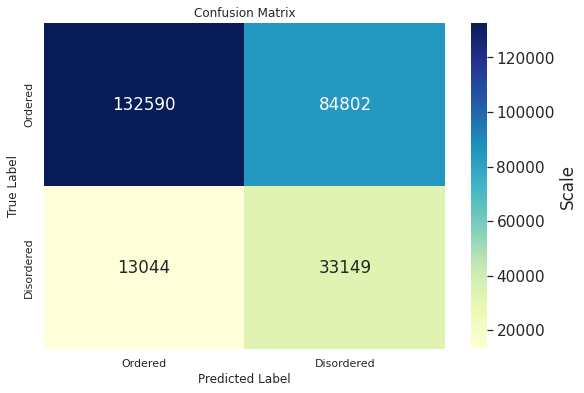

Accuracy:	  tensor(0.6288)
Precision:	  tensor(0.2810)
Recall:		  tensor(0.7176)
F1 score:	  tensor(0.4039)


In [23]:
calculate_dataset_metrics("Test", test_loader)